In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, Imputer
import tflscripts
configuration = tflscripts.read_configuration()

In [3]:
configuration['device_roles']['synergy-final-iter4']

{'128.237.227.76': 'Mite 2 Sink',
 '128.237.247.190': 'Mite 1 Table',
 '128.237.250.218': 'Mite 4 Coffee',
 'Matrix b827eb41f96f': 'Matrix 3 Coffee',
 'Matrix b827eb96f31a': 'Matrix 1 Table',
 'Matrix b827ebe6e0f8': 'Matrix 2 Sink',
 'xdk_1': 'XDK 1 Sink',
 'xdk_2': 'XDK 2 Coffee',
 'xdk_3': 'XDK 3 Table'}

In [72]:
dataset_path = '../datasets/synergy-final-iter42-1s-processed/'

In [14]:
labels = pd.read_pickle(dataset_path + '128.237.227.76_labels.p')
windows = labels.loc[labels.label == configuration['activities'].index('Null')].window_id.values
windows

array([1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544,
       1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555,
       1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566,
       1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577,
       1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588,
       1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599,
       1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610,
       1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621,
       1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632,
       1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643,
       1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654,
       1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665,
       1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676,
       1677, 1678, 1679, 1680, 1681, 1682, 1683, 16

In [6]:
# robotics dataset
vibrating_window_id = 321
chopping_food_window_id = 115
kettle_window_id = 79
null_window_id = 3

# scott iter 1
# vibrating_window_id = 318
# chopping_food_window_id = 101
# null_window_id = 3

# df_labels = pd.read_pickle(dataset_path + 'xdk_1_labels.p')
# df_labels.loc[df_labels.label == 3]

In [70]:
def rename_location(loc):
    names = {
        'Coffee': 'C',
        'Table': 'A',
        'Sink': 'B'
    }
    if loc in names:
        return 'Placement: ' + names[loc]
    return loc

def plot_features(devices, device_labels, activities, datasets=None, features='accel_x', title='', y_label='', common_scaler=False,
                 width=10, height=2, axes=None, show_titles=True):
    plt.rcParams["figure.figsize"] = (width, height)
    dfs = []
    if axes is None:
        fig, axes = plt.subplots(1, len(devices), sharex=True, sharey=True)
    
    if common_scaler:
        dfs = []
        for i, device in enumerate(devices):
            ds_path = dataset_path
            if datasets is not None:
                ds_path = '../datasets/' + datasets[i] + '-1s-processed/'

            df = pd.read_pickle(ds_path + device + '.p')
            columns = df.filter(regex=features).columns
            df_labels = pd.read_pickle(dataset_path + device + '_labels.p')

            for activity in activities:
                since_window_id = activities[activity][0]
                until_window_id = activities[activity][1]
                since_id = df_labels.loc[df_labels.window_id == since_window_id].index[0]
                until_id = df_labels.loc[df_labels.window_id == until_window_id].index[0]

                subdf = df
                subdf = subdf.loc[subdf.id >= since_id]
                subdf = subdf.loc[subdf.id <= until_id]
                subdf = subdf[columns]
                subdf = subdf.reset_index(drop=True)

                dfs.append(subdf)

        conc = pd.concat(dfs, axis=0)
        scaler = StandardScaler()
        scaler.fit(conc[conc.columns])
        
    
    for i, device in enumerate(devices):
        print(device)
        df = pd.read_pickle(dataset_path + device + '.p')
        columns = df.filter(regex=features).columns
        df_labels = pd.read_pickle(dataset_path + device + '_labels.p')
        subdfs = []

        for activity in activities:
            since_window_id = activities[activity][0]
            until_window_id = activities[activity][1]
            since_id = df_labels.loc[df_labels.window_id == since_window_id].index[0]
            until_id = df_labels.loc[df_labels.window_id == until_window_id].index[0]


            subdf = df
            subdf = subdf.loc[subdf.id >= since_id]
            subdf = subdf.loc[subdf.id <= until_id]
            subdf = subdf[columns]
            subdf = subdf.reset_index(drop=True)

            subdfs.append(subdf)

        conc = pd.concat(subdfs, axis=0)
        if not common_scaler:
            scaler = StandardScaler()
            scaler.fit(conc[conc.columns])

        ssubdfs = []
        for subdf in subdfs:
            subdf[columns] = scaler.transform(subdf[columns])
            ssubdfs.append(subdf)

        df = pd.concat(ssubdfs, axis=1)
        df.columns = list(range(len(df.columns)))

        for col in df.columns:
            df = df[pd.notnull(df[col])]

#         df = df[columns]
        df.columns = activities
        df = df.reset_index(drop=True)
        
        for col in df.columns:
            df = df[pd.notnull(df[col])]

        df.index = df.index / 10
        df.plot(ax=axes[i])
        matplotlib.pyplot.sca(axes[i])
        axes[i].legend().set_visible(i == 0)
        if i == 0:
            plt.ylabel(y_label)
        plt.xlabel('Time (s)')
        if show_titles:
            plt.title(rename_location(device_labels[i]))
#         plt.show()
#         dfs.append(df)

    plt.suptitle(title)


def plot_features_same_plot(devices, device_labels, activities, datasets=None, features='accel_x', title='', y_label='', common_scaler=False,
                 width=10, height=2):
    plt.rcParams["figure.figsize"] = (width, height)
    dfs = []
    
    if common_scaler:
        dfs = []
        for i, device in enumerate(devices):
            ds_path = dataset_path
            if datasets is not None:
                ds_path = '../datasets/' + datasets[i] + '-1s-processed/'

            df = pd.read_pickle(ds_path + device + '.p')
            columns = df.filter(regex=features).columns
            df_labels = pd.read_pickle(dataset_path + device + '_labels.p')

            for activity in activities:
                since_window_id = activities[activity][0]
                until_window_id = activities[activity][1]
                since_id = df_labels.loc[df_labels.window_id == since_window_id].index[0]
                until_id = df_labels.loc[df_labels.window_id == until_window_id].index[0]

                subdf = df
                subdf = subdf.loc[subdf.id >= since_id]
                subdf = subdf.loc[subdf.id <= until_id]
                subdf = subdf[columns]
                subdf = subdf.reset_index(drop=True)

                dfs.append(subdf)

        conc = pd.concat(dfs, axis=0)
        scaler = StandardScaler()
        scaler.fit(conc[conc.columns])
        
    _dfs = []
    for i, device in enumerate(devices):
        print(device)
        df = pd.read_pickle(dataset_path + device + '.p')
        columns = df.filter(regex=features).columns
        df_labels = pd.read_pickle(dataset_path + device + '_labels.p')
        subdfs = []

        for activity in activities:
            since_window_id = activities[activity][0]
            until_window_id = activities[activity][1]
            since_id = df_labels.loc[df_labels.window_id == since_window_id].index[0]
            until_id = df_labels.loc[df_labels.window_id == until_window_id].index[0]


            subdf = df
            subdf = subdf.loc[subdf.id >= since_id]
            subdf = subdf.loc[subdf.id <= until_id]
            subdf = subdf[columns]
            subdf = subdf.reset_index(drop=True)

            subdfs.append(subdf)

        conc = pd.concat(subdfs, axis=0)
        if not common_scaler:
            scaler = StandardScaler()
            scaler.fit(conc[conc.columns])

        ssubdfs = []
        for subdf in subdfs:
            subdf[columns] = scaler.transform(subdf[columns])
            ssubdfs.append(subdf)

        df = pd.concat(ssubdfs, axis=1)
        df.columns = list(range(len(df.columns)))

        for col in df.columns:
            df = df[pd.notnull(df[col])]

#         df = df[columns]
        df.columns = [device_labels[i]]
        df = df.reset_index(drop=True)
        
        for col in df.columns:
            df = df[pd.notnull(df[col])]

        df.index = df.index / 10
        _dfs.append(df)
    
    df = pd.concat(_dfs, axis=1)
    df.plot()

    plt.ylabel(y_label)
    plt.xlabel('Time (s)')
    plt.title(rename_location(''.join(activities)))
#         plt.show()
#         dfs.append(df)

#     plt.suptitle(title)  

xdk_2
128.237.254.195
Matrix b827eb41f96f


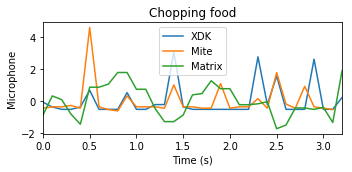

In [69]:
plt.rcParams["figure.figsize"] = (7, 3)

since = 3932
until = 3934
features = 'microphone$'

plot_features_same_plot([
    'xdk_2',
    '128.237.254.195',
    'Matrix b827eb41f96f'
], [
   'XDK', 'Mite', 'Matrix' 
], activities={
    'Chopping food': [since, until]
}, features=features, title='Chopping food (microphone)', y_label='Microphone', width=5, height=2.5)
# plot_features('Matrix b827eb96f31a', since, until, features=features)

plt.tight_layout()
plt.savefig('plots/chopping_food_data_different_devices.pdf')

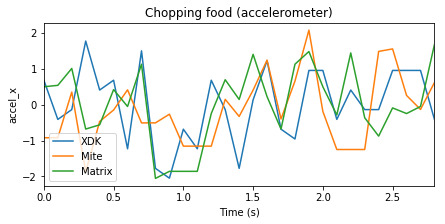

In [225]:
plt.rcParams["figure.figsize"] = (7, 3)

since = 774
until = 776
features = 'accel_x'

plot_features([
    'xdk_2',
    '128.237.254.195',
    'Matrix b827eb41f96f'
], [
   'XDK', 'Mite', 'Matrix' 
], activities={
    'Chopping food': [since, until]
}, features=features, title='Chopping food (accelerometer)')
# plot_features('Matrix b827eb96f31a', since, until, features=features)

xdk_2
128.237.250.218
Matrix b827eb41f96f
xdk_2
128.237.250.218
Matrix b827eb41f96f


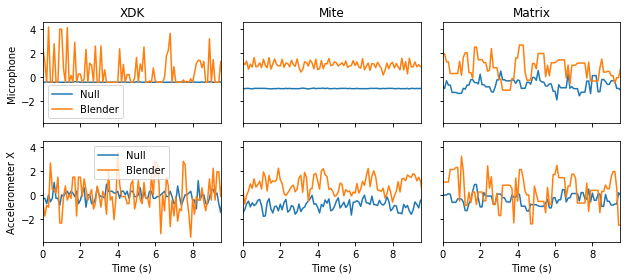

In [73]:
plt.rcParams["figure.figsize"] = (9, 4)

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)

plot_features([
    'xdk_2',
    '128.237.250.218',
    'Matrix b827eb41f96f'
], [
   'XDK', 'Mite', 'Matrix' 
], activities={
    'Blender': [260, 270],
    'Null': [3380, 3390]
}, features='microphone$', title='', y_label='Microphone', axes=axes[0])
# plot_features('Matrix b827eb96f31a', since, until, features=features)
plot_features([
    'xdk_2',
    '128.237.250.218',
    'Matrix b827eb41f96f'
], [
   'XDK', 'Mite', 'Matrix' 
], activities={
    'Blender': [260, 270],
    'Null': [3380, 3390]
}, features='accel_x', title='', y_label='Accelerometer X', axes=axes[1],
show_titles=False)
# plot_features('Matrix b827eb96f31a', since, until, features=features)

plt.tight_layout()
plt.savefig('plots/sensor_data_across_devices.pdf')

xdk_2
128.237.250.218
Matrix b827eb41f96f


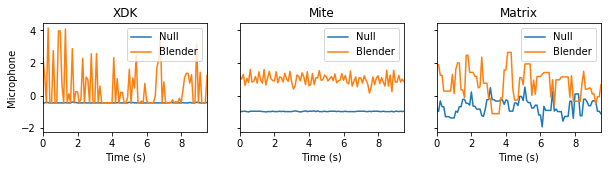

128.237.227.76
128.237.250.218
128.237.247.190
128.237.227.76
128.237.250.218
128.237.247.190


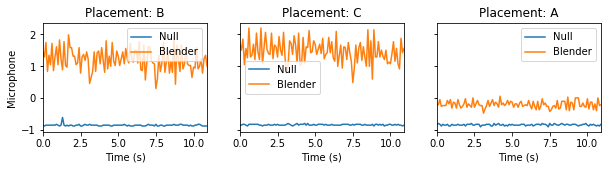

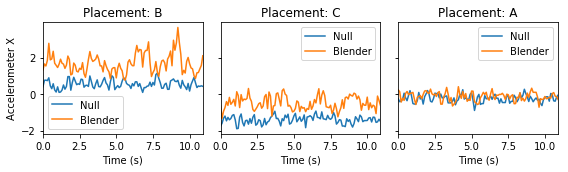

128.237.227.76
128.237.250.218
128.237.247.190


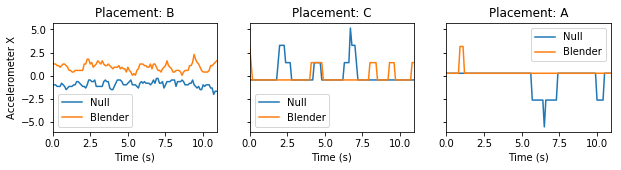

In [27]:
plot_features([
    '128.237.227.76',
    '128.237.250.218',
    '128.237.247.190'
], [
   'Sink', 'Coffee', 'Table'
], activities={
    'Blender': [260, 270],
    'Null': [3380, 3390]
}, features='microphone$', title='', y_label='Microphone', common_scaler=True)
# plot_features('Matrix b827eb96f31a', since, until, features=features)

plot_features([
    '128.237.227.76',
    '128.237.250.218',
    '128.237.247.190'
], [
   'Sink', 'Coffee', 'Table'
], activities={
    'Blender': [260, 270],
    'Null': [3380, 3390]
}, features='accel_x', title='', y_label='Accelerometer X', common_scaler=True, width=8, height=2.5)
plt.tight_layout()
plt.savefig('plots/accelerometer_data_by_placements.pdf')
plt.show()
# plot_features('Matrix b827eb96f31a', since, until, features=features)

plot_features([
    '128.237.227.76',
    '128.237.250.218',
    '128.237.247.190'
], [
   'Sink', 'Coffee', 'Table'
], activities={
    'Blender': [260, 270],
    'Null': [3380, 3390]
}, features='mag_x', title='', y_label='Accelerometer X', common_scaler=False)
# plot_features('Matrix b827eb96f31a', since, until, features=features)

128.237.227.76
128.237.250.218
128.237.247.190


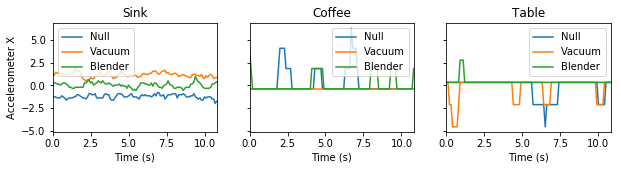

In [51]:

plot_features([
    '128.237.227.76',
    '128.237.250.218',
    '128.237.247.190'
], [
   'Sink', 'Coffee', 'Table'
], activities={
    'Blender': [260, 270],
    'Null': [3380, 3390],
    'Vacuum': [100, 110],
}, features='mag_x', title='', y_label='Accelerometer X', common_scaler=False)
# plot_features('Matrix b827eb96f31a', since, until, features=features)

128.237.227.76
128.237.250.218


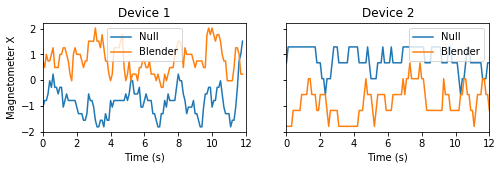

In [68]:
plot_features([
    '128.237.227.76',
    '128.237.250.218'
], [
   'Device 1', 'Device 2'
], datasets=[
   'synergy-final-iter42',
   'synergy-final-iter5'
], activities={
    'Blender': [260, 270],
    'Null': [3360, 3370],
}, features='mag_x', title='', y_label='Magnetometer X', common_scaler=False, width=8)
# plot_features('Matrix b827eb96f31a', since, until, features=features)